<a href="https://colab.research.google.com/github/GeorgeThan414/Machine_Learning_CSD/blob/main/Exercise10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries


In [70]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

# Load the dataset

In [22]:
zip_path="spotify.zip"
extract_path = "spotify_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dfs = []
for file in os.listdir(extract_path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(extract_path, file))
        dfs.append(df)

spotify_df = pd.concat(dfs, ignore_index=True)
print(spotify_df.shape)

(114000, 21)


In [23]:
spotify_df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

# Task 1 A) :
Remove Number, Track id , Artists, Album Name, Track Name

In [24]:
meta_cols = [
    "Unnamed: 0",
    "track_id",
    "artists",
    "album_name",
    "track_name"
]

metadata_df = spotify_df[meta_cols].copy()
features_df = spotify_df.drop(columns=meta_cols)

# Task 1 B):
One-Hot Encoding in Genres

In [25]:
genre_col = "track_genre"
encoder = OneHotEncoder(sparse_output=False,handle_unknown="ignore")
genre_encoded = encoder.fit_transform(features_df[[genre_col]])

genre_df = pd.DataFrame(genre_encoded,columns=encoder.get_feature_names_out([genre_col]))

features_df = features_df.drop(columns=[genre_col])
features_df = pd.concat([features_df.reset_index(drop=True),genre_df.reset_index(drop=True)],axis=1)

In [26]:
print(genre_df.shape)

(114000, 114)


# Task 2 - Normalization

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# Task 3

In [33]:
k_values = [2, 3, 5, 7, 10, 15, 20]
sse = []

for k in k_values:
  kmeans = KMeans(n_clusters=k,init="k-means++",max_iter=1000, random_state=42)
  kmeans.fit(X_scaled)
  sse.append(kmeans.inertia_)

  print(f"k={k}, SSE={kmeans.inertia_:.2f}")

k=2, SSE=14423469.60
k=3, SSE=14280326.82
k=5, SSE=14021875.78
k=7, SSE=13776524.80
k=10, SSE=13370978.96
k=15, SSE=12773647.17
k=20, SSE=12197400.35


# Line Plot

Bellow line plots does not have an elbow, in roder to identify the best number of clusters. One reason is the many features that dataset has, which means many dimensions and euclidean distances cannot perform well. Another reason is that K-Means works better with continuing features, because it calculates the means, while the one-hot is binary encoding with not mean.

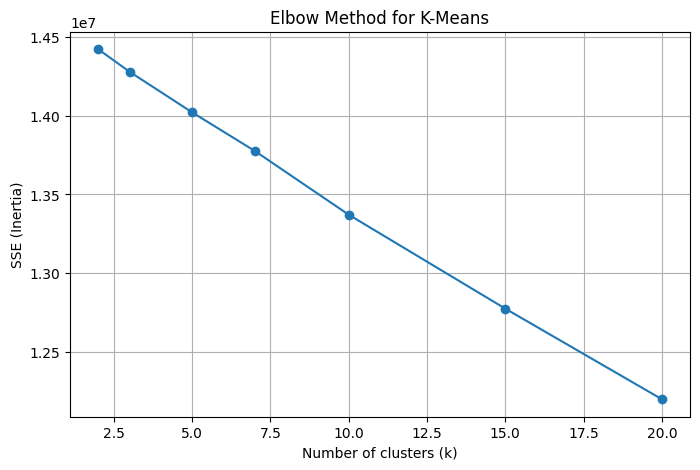

In [40]:
plt.figure(figsize=(8,5))
plt.plot(k_values, sse, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for K-Means")
plt.grid(True)
plt.show()

# In order to indentify the elbow we will reduce the total dimensions by remove some additional features. Therefore one-hot encoding will not be applied to the data.

In [44]:
audio_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "popularity"
]
X_audio = spotify_df[audio_features].copy()
print(X_audio.shape)
scaler = StandardScaler()
X_audio_scaled = scaler.fit_transform(X_audio)

(114000, 11)


In [46]:
k_values = [2, 3, 5, 7, 10, 15, 20]
sse_audio = []

for k in k_values:
    kmeans = KMeans(n_clusters=k,n_init=10,random_state=42)
    kmeans.fit(X_audio_scaled)
    sse_audio.append(kmeans.inertia_)

    print(f"k={k}, SSE={kmeans.inertia_:.2f}")

k=2, SSE=1033237.01
k=3, SSE=939642.95
k=5, SSE=807219.59
k=7, SSE=711743.38
k=10, SSE=613637.31
k=15, SSE=530855.54
k=20, SSE=483617.21


# Bsed on bellow elbow plot, we will choose the k=10 as best option

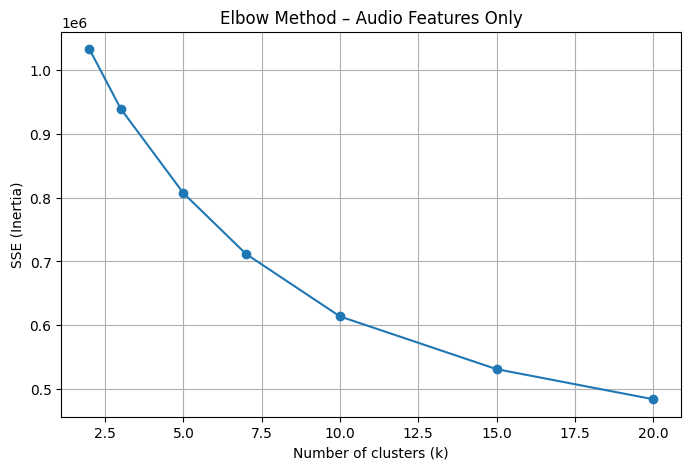

In [47]:
plt.figure(figsize=(8,5))
plt.plot(k_values, sse_audio, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method – Audio Features Only")
plt.grid(True)
plt.show()

# task 4  k=10

In [50]:
optimal_k = 10
kmeans_final = KMeans(n_clusters=optimal_k,n_init=10,random_state=42)
labels = kmeans_final.fit_predict(X_audio_scaled)
spotify_df["cluster"] = labels

# Task - 5  Bar Plot

In [51]:
spotify_df[["track_name", "track_genre", "cluster"]].head()

,track_name,track_genre,cluster
0,Comedy,acoustic,7
1,Ghost - Acoustic,acoustic,5
2,To Begin Again,acoustic,8
3,Can't Help Falling In Love,acoustic,5
4,Hold On,acoustic,8


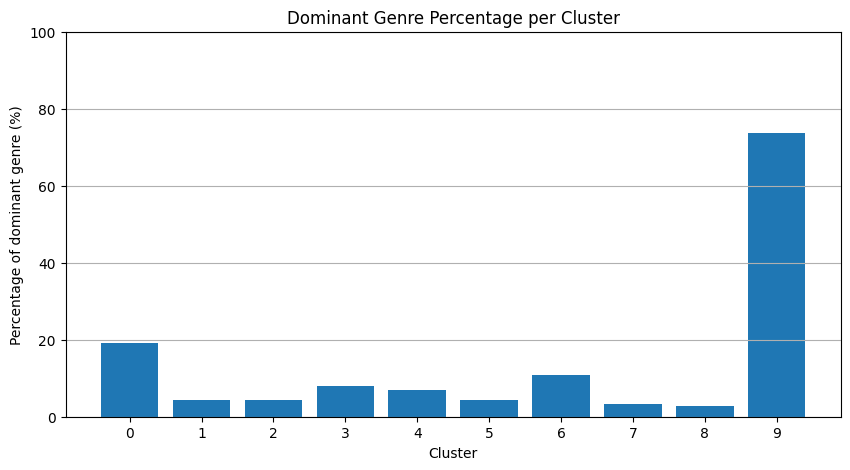

In [53]:
# Genres were not used in clustering
dominant_stats = []

for cluster_id in sorted(spotify_df["cluster"].unique()):

    subset = spotify_df[spotify_df["cluster"] == cluster_id]
    total = len(subset)

    genre_counts = subset["track_genre"].value_counts()

    dominant_genre = genre_counts.idxmax()
    dominant_count = genre_counts.max()

    percentage = dominant_count / total * 100

    dominant_stats.append({
        "cluster": cluster_id,
        "dominant_genre": dominant_genre,
        "percentage": percentage
    })

dominant_df = pd.DataFrame(dominant_stats)

plt.figure(figsize=(10,5))
plt.bar(dominant_df["cluster"], dominant_df["percentage"])

plt.xlabel("Cluster")
plt.ylabel("Percentage of dominant genre (%)")
plt.title("Dominant Genre Percentage per Cluster")
plt.xticks(dominant_df["cluster"])
plt.ylim(0, 100)
plt.grid(axis="y")

plt.show()

# Task 6

In [65]:
# Selecting a asong
song_title = "Shape of You"
# Identify is live in the dataset
song_idx = spotify_df[spotify_df["track_name"] == song_title].index[0]
selected_song = spotify_df.loc[song_idx]

print("Title:", selected_song["track_name"])
print("Artist:", selected_song["artists"])
print("Cluster:", selected_song["cluster"])
# Collecting the cluster id and in which cluster the song belongs
cluster_id = selected_song["cluster"]
same_cluster_idx = spotify_df[spotify_df["cluster"] == cluster_id].index

# Calucaltiogn the distances of this song and the closer three
song_vector = X_audio_scaled[song_idx].reshape(1, -1)
cluster_vectors = X_audio_scaled[same_cluster_idx]

distances = euclidean_distances(song_vector, cluster_vectors).flatten()

distance_df = spotify_df.loc[same_cluster_idx, ["track_name", "artists"]].copy()
distance_df["distance"] = distances
# remove the same song
distance_df = distance_df[distance_df.index != song_idx]

top_3 = distance_df.sort_values("distance").head(3)
print(top_3)

Title: Shape of You
Artist: Ed Sheeran
Cluster: 7
                                       track_name                     artists  \
21053                                  On the Low                   Burna Boy   
25265                              You Sexy Thing               Hot Chocolate   
104186  Colgando en tus manos (con Marta Sánchez)  Carlos Baute;Marta Sánchez   

        distance  
21053   1.028479  
25265   1.040360  
104186  1.090543  


# Task -7 Cosine similarity

In [69]:
song_idx = spotify_df[spotify_df["track_name"] == song_title].index[0]
cluster_id = spotify_df.loc[song_idx, "cluster"]
song_vector = X_audio_scaled[song_idx].reshape(1, -1)
cluster_vectors = X_audio_scaled[same_cluster_idx]

cos_sim = cosine_similarity(song_vector, cluster_vectors).flatten()
cos_distance = 1 - cos_sim
distance_df_cos = spotify_df.loc[same_cluster_idx,["track_name", "artists"]].copy()

distance_df_cos["cosine_distance"] = cos_distance

# remove the same song
distance_df_cos = distance_df_cos[
    distance_df_cos.index != song_idx
]

top_3_cosine = distance_df_cos.sort_values("cosine_distance").head(3)

print(top_3_cosine)

                                        track_name                    artists  \
81076  Srivalli (From "Pushpa The Rise Part - 01")  Javed Ali;Devi Sri Prasad   
80018  Srivalli (From "Pushpa The Rise Part - 01")  Javed Ali;Devi Sri Prasad   
25265                               You Sexy Thing              Hot Chocolate   

       cosine_distance  
81076         0.029438  
80018         0.029438  
25265         0.029823  


# Task 9 hdbscan

In [72]:
!pip install hdbscan

In [73]:
import hdbscan
audio_features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo", "duration_ms", "popularity"
]

X_audio = spotify_df[audio_features].copy()

scaler = StandardScaler()
X_audio_scaled = scaler.fit_transform(X_audio)
hdb = hdbscan.HDBSCAN(min_cluster_size=200,min_samples=20,metric="euclidean")
hdb_labels = hdb.fit_predict(X_audio_scaled)
unique_labels_hdb = set(hdb_labels)

n_clusters_hdb = len(unique_labels_hdb) - (1 if -1 in unique_labels_hdb else 0)
n_noise_hdb = np.sum(hdb_labels == -1)

print("HDBSCAN clusters:", n_clusters_hdb)
print("Noise points:", n_noise_hdb)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


HDBSCAN clusters: 2
Noise points: 3424


Above algorithm, only found 2 clusters, and 3424 noisy points. This results shows that the data density is high and only 2 main clusters can be separated.